# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install fuzzywuzzy

In [4]:
# importing libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
from fuzzywuzzy import fuzz

import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk import tokenize
import re
import gensim
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Loading Lexicons

In [0]:
# reading the different lexicons and defining negative words
negative_words = ["no", "not", "not any", "none", "never", "neither", "nor", "few", "hardly", "little", "scarcely", "rarely", "seldom", "isn't", "don't", "can't", "hadn't"]

xlsx_file = '/content/drive/My Drive/Sustainable-Peace-Project/BBCLexicon.xlsx'
dfs = pd.read_excel(xlsx_file)
dfs = dfs.drop(['Unnamed: 1','Unnamed: 2','Unnamed: 3'], axis=1)
dfs.columns = ['Peace_Lexicon']
#preprocessing the peace lexicon words 
dfs['Peace_Lexicon'] = dfs['Peace_Lexicon'].str.lower()
dfs['Peace_Lexicon'] = dfs['Peace_Lexicon'].str.replace("_", " ")
dfs['Peace_Lexicon'] = dfs['Peace_Lexicon'].str.strip()
peace_lexicon_list = list(dfs.Peace_Lexicon)

conflict_file = '/content/drive/My Drive/Sustainable-Peace-Project/NewsLexicon-Conflict.csv'
dfs = pd.read_csv(conflict_file)
dfs.columns = ['Conflict_Lexicon']
#preprocessing the conflict lexicon words 
dfs['Conflict_Lexicon'] = dfs['Conflict_Lexicon'].str.lower()
dfs['Conflict_Lexicon'] = dfs['Conflict_Lexicon'].str.replace("_", " ")
dfs['Conflict_Lexicon'] = dfs['Conflict_Lexicon'].str.strip()
conflict_lexicon_list = list(dfs.Conflict_Lexicon)

nonPeace_file = '/content/drive/My Drive/Sustainable-Peace-Project/non_peaceful.csv'
dfs = pd.read_csv(nonPeace_file)
dfs.columns = ['NonPeaceful_Lexicon']
#preprocessing the non peace lexicon words
dfs['NonPeaceful_Lexicon'] = dfs['NonPeaceful_Lexicon'].str.lower()
dfs['NonPeaceful_Lexicon'] = dfs['NonPeaceful_Lexicon'].str.replace("_", " ")
dfs['NonPeaceful_Lexicon'] = dfs['NonPeaceful_Lexicon'].str.strip()
nonPeace_lexicon_list = list(dfs.NonPeaceful_Lexicon)

# Defining functions

In [0]:
# building the gensim model
def build_model(text, lexicon):
  # iterate through each sentence in the file 

  text.append(lexicon)

  model = gensim.models.Word2Vec(text, min_count = 1,  
                                size = 100, window = 5, sg = 1)
  return model

In [0]:
# scraping data from bbc.com
def bbc_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.findAll('p') 
    article = article[12:27]
    news_article = ""
    for a in article:
        temp = a.get_text()
        news_article = news_article + " " + temp
    return news_article
# preprocessing with the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[!@#$,"()'':]', '', text.lower())
    return(text)
# functions for finding the peace / non-peace / conflict scores - 
def peace_score(words, lexicon):
    peace_list = []
    t = []
    score = 0
    for x in words:
        for y in x:
            temp = compare_terms(y, lexicon)
            if y in negative_words and flag == 0:
                # print(y)
                flag = 1
            elif temp != None and flag == 0:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score + 1
            elif temp != None and flag == 1:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score - 1
                flag = 0
        flag = 0
    return peace_list, score
# function to compare terms
def compare_terms(term, lexicon):
    for i in lexicon:
      term = term.strip(' ')
      term = term.strip('.')
      # term = term.strip('\'s')
      if term != '' and fuzz.ratio(term, i) > 85 and model.similarity(term, i) > 0.1:
        return i

In [0]:
# scraping data from the Google News API
# this function will find BBC news articles from a particular country in English Language
def google_news_articles(country):
    url = ('https://newsapi.org/v2/everything?'
           'domains=bbc.com&'
           'q=' + country + '&'
           'language=en&'
           'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
    response = requests.get(url)
    #print(response.json())
    news = response.json()['articles']
    desc = []
    for i in range(len(news)):
        desc.append(news[i]['description'])
    url = []
    for i in range(len(news)):
        url.append(news[i]['url'])
    return url, desc

# Getting data from the Google News API

In [0]:
urls, descs = google_news_articles('Canada')
urls

['https://www.bbc.com/news/world-us-canada-52022506',
 'https://www.bbc.com/news/world-us-canada-51980681',
 'http://www.bbc.com/travel/story/20200309-ogopogo-the-monster-lurking-in-okanagan-lake',
 'https://www.bbc.com/news/world-us-canada-51970815',
 'https://www.bbc.com/news/world-us-canada-51949243',
 'https://www.bbc.com/news/world-middle-east-51809818',
 'https://www.bbc.com/news/world-us-canada-51860702',
 'https://www.bbc.com/news/world-us-canada-51989255',
 'https://www.bbc.com/news/world-52000044',
 'https://www.bbc.com/news/uk-51800196',
 'https://www.bbc.com/news/world-us-canada-51796024',
 'https://www.bbc.com/news/business-52045889',
 'https://www.bbc.com/news/world-us-canada-51636831',
 'https://www.bbc.com/news/world-us-canada-51812153',
 'https://www.bbc.com/news/world-middle-east-51723398',
 'https://www.bbc.com/news/business-51980671',
 'https://www.bbc.com/news/world-middle-east-51783242',
 'https://www.bbc.com/news/world-europe-51777049',
 'https://www.bbc.com/news

In [0]:
urls_canada = urls
desc_canada = descs

In [0]:
canada_articles = []
for i in urls:
  canada_articles.append(bbc_news(i))

In [0]:
cscore = 0
for i in canada_articles:
  i = i.lower()
  j = i.split()
  if 'coronavirus' in j or 'covid-19' in j:
    cscore += 1
cscore

15

In [0]:
canada_df = pd.DataFrame(canada_articles)

In [0]:
canada_df.to_csv('canada.csv')
!cp canada.csv "drive/My Drive/Sustainable-Peace-Project/"

In [0]:
# urls_newzealand, desc_newzealand = google_news_articles('New Zealand')
nz_articles = []
for i in urls_newzealand:
  nz_articles.append(bbc_news(i))
nzscore = 0
for i in nz_articles:
  i = i.lower()
  j = i.split()
  if 'coronavirus' in j or 'covid-19' in j:
    nzscore += 1
print(nzscore)
nz_df = pd.DataFrame(nz_articles)
nz_df.to_csv('nz.csv')
!cp nz.csv "drive/My Drive/Sustainable-Peace-Project/"

7


In [0]:
urls_turkey, desc_turkey = google_news_articles('Turkey')
turkey_articles = []
for i in urls_turkey:
  turkey_articles.append(bbc_news(i))
tscore = 0
for i in turkey_articles:
  i = i.lower()
  j = i.split()
  if 'coronavirus' in j or 'covid-19' in j:
    tscore += 1
print(tscore)
t_df = pd.DataFrame(turkey_articles)
t_df.to_csv('turkey.csv')
!cp turkey.csv "drive/My Drive/Sustainable-Peace-Project/"

In [0]:
urls_ven, desc_ven = google_news_articles('Venezuela')
ven_articles = []
for i in urls_ven:
  ven_articles.append(bbc_news(i))
vscore = 0
for i in ven_articles:
  i = i.lower()
  j = i.split()
  if 'coronavirus' in j or 'covid-19' in j:
    vscore += 1
print(vscore)
v_df = pd.DataFrame(ven_articles)
v_df.to_csv('venezuela.csv')
!cp venezuela.csv "drive/My Drive/Sustainable-Peace-Project/"

1


In [0]:
urls_sweden, desc_sweden = google_news_articles('Sweden')
sweden_articles = []
for i in urls_sweden:
  sweden_articles.append(bbc_news(i))
sscore = 0
for i in sweden_articles:
  i = i.lower()
  j = i.split()
  if 'coronavirus' in j or 'covid-19' in j:
    sscore += 1
print(sscore)
sweden_df = pd.DataFrame(sweden_articles)
sweden_df.to_csv('sweden.csv')
!cp sweden.csv "drive/My Drive/Sustainable-Peace-Project/"

4


In [0]:
print('Canada has ' + str(cscore) + ' COVID-19 articles from ' + str(len(desc_canada)) + ' articles')
print('New Zealand has ' + str(nzscore) + ' COVID-19 articles from ' + str(len(desc_newzealand)) + ' articles')
print('Sweden has ' + str(sscore) + ' COVID-19 articles from ' + str(len(desc_sweden)) + ' articles')
print('Turkey has ' + str(tscore) + ' COVID-19 articles from ' + str(len(desc_turkey)) + ' articles')
print('Venezuela has ' + str(vscore) + ' COVID-19 articles from ' + str(len(desc_ven)) + ' articles')

Canada has 15 COVID-19 articles from 20 articles
New Zealand has 7 COVID-19 articles from 18 articles
Sweden has 4 COVID-19 articles from 9 articles
Turkey has 1 COVID-19 articles from 20 articles
Venezuela has 1 COVID-19 articles from 5 articles


In [0]:
per_of_covid_articles = [1500/20, 700/18, 400/9, 100/5, 100/20]
countries = ['Canada', 'New Zealand', 'Sweden', 'Venezuela', 'Turkey']

Text(0, 0.5, 'Percentage of COVID articles')

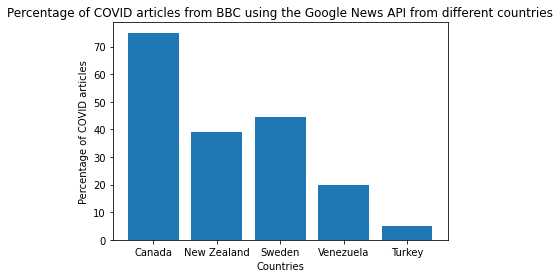

In [0]:
plt.bar(countries, per_of_covid_articles)
plt.title('Percentage of COVID articles from BBC using the Google News API from different countries')
plt.xlabel('Countries')
plt.ylabel('Percentage of COVID articles')

# Working on using the data scraped from the web

In [0]:
canada_data = ''
for i in canada_articles:
  canada_data = canada_data + ' ' + i

In [0]:
canada_data_processed = preprocess_text(canada_data)
model = build_model(canada_data_processed)
canada_list, c_peacescore = peace_score(canada_data_processed)
canada_list

In [0]:
turkey_data = ''
for i in turkey_articles:
  turkey_data = turkey_data + ' ' + i

turkey_data_processed = preprocess_text(turkey_data)
model = build_model(turkey_data_processed)
turkey_list, t_peacescore = peace_score(turkey_data_processed)

KeyError: ignored

# Google News - Country wise with no restriction on the source

In [0]:
def google_news_articles(country):
    url = ('https://newsapi.org/v2/top-headlines?'
           'country=' + country + '&'
           'language=en&'
           'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
    response = requests.get(url)
    #print(response.json())
    news = response.json()['articles']
    desc = []
    for i in range(len(news)):
        desc.append(news[i]['description'])
    url = []
    for i in range(len(news)):
        url.append(news[i]['url'])
    return url, desc
urls = dict()
descs = dict()
countries = ['ca', 'nz', 'tr', 've']
for i in countries:
  urls[i], descs[i] = google_news_articles(i)

In [0]:
cscores = dict()
for k, v in descs.items():
  t = 0
  v = list(filter(None.__ne__, v))
  for i in v:
    i = i.lower()
    j = i.split()
    if ('coronavirus' in j) or ('covid-19' in j) or ('covid' in j):
      t += 1
  cscores[k] = t

cscores

{'ca': 8, 'nz': 8, 'tr': 0, 've': 1}

In [0]:
descs['ve']

['Android Auto llega al mundo de las motocicletas poco más de dos años después de que CarPlay de Apple comenzó a aparecer en vehículos de dos ruedas',
 'El Departamento de Estado norteamericano presentó la hoja de ruta para que el régimen latinoamericano deje el poder. Dentro del programa existen señales inequívocas para gran parte de la actual administración',
 'Conozca el precio del dólar en Venezuela mientras el líder chavista Nicolás Maduro asegura que la justicia les “va a llegar a todos los terroristas”',
 'El 29 de abril, un asteroide estimado entre 1,7 kilómetros de largo y 4,1 kilómetros de ancho volará sobre la Tierra. Pero no se espera que choque con nuestro planeta, afortunadamente. Si lo ...',
 'Arabia Saudita se prepara para inundar los mercados de petróleo con una oleada de producción que amenaza a sus socios de la OPEP',
 'Estados Unidos lanzó una propuesta para establecer un gobierno de transición en Venezuela en el que no están incluídos ni el cuestionado presidente N

In [0]:
response.json()

{'articles': [{'author': 'https://www.facebook.com/bbcnews',
   'content': 'Image copyrightGetty Images\r\nVenezuelan President Nicolás Maduro has urged women to have six children "for the good of the country".\r\nAppearing at a televised event promoting a national women\'s healthcare plan, Mr Maduro instructed women to "give birth, give … [+1781 chars]',
   'description': "Venezuela's Maduro urges women to have six children BBC News Venezuela's Nicolas Maduro urges women to have six children ‘for the good of the country’ Fox News Venezuela moves to seize shipping agents' assets over debts to PDVSA: sources, document Reuters Ven…",
   'publishedAt': '2020-03-04T12:53:50Z',
   'source': {'id': None, 'name': 'Bbc.com'},
   'title': "Venezuela's Maduro urges women to have six children - BBC News",
   'url': 'https://www.bbc.com/news/world-latin-america-51735025',
   'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/2777/production/_111130101_gettyimagesmaduro.jpg'},
  {'autho

In [0]:
url = ('https://newsapi.org/v2/top-headlines?'
        'country=' + 've' + '&'
        'language=en&'
        'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
response = requests.get(url)

In [0]:
response.json()

{'articles': [{'author': None,
   'content': 'Android Auto finalmente está llegando al mundo de las motocicletas poco más de dos años después de que CarPlay de Apple comenzó a aparecer en vehículos de dos ruedas. Harley-Davidson anunció recientemente la compatibilidad con Android Auto en cualquiera de su… [+1665 chars]',
   'description': 'Android Auto llega al mundo de las motocicletas poco más de dos años después de que CarPlay de Apple comenzó a aparecer en vehículos de dos ruedas',
   'publishedAt': '2020-03-31T18:30:36Z',
   'source': {'id': None, 'name': 'Altadensidad.com'},
   'title': 'Android Auto aterriza en Harley-Davidson - Alta Densidad',
   'url': 'https://altadensidad.com/android-auto-aterriza-en-harley-davidson/',
   'urlToImage': 'https://altadensidad.com/wp-content/uploads/2020/03/Andriod_Auto_Harley_Davidson.0.jpg'},
  {'author': None,
   'content': 'El secretario de Estado estadounidense, Mike Pompeo, presentó este martes en Washington un Marco de Transición Democrá

# Preprocessing the lexicon

In [0]:
input_str = 'NLTK is a leading platform for building Python programs to work with human language data.'

# stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
tokens = word_tokenize(input_str)
result = [i for i in tokens if not i in ENGLISH_STOP_WORDS]
print (result)

['NLTK', 'leading', 'platform', 'building', 'Python', 'programs', 'work', 'human', 'language', 'data', '.']


In [0]:

for i in peace_lexicon_list:
  input_str=word_tokenize(i)
  j = []
  for word in input_str:
      j.append(stemmer.stem(word))
  temp = ' '.join(j)
  if i != temp:
    print(i + ',' + temp)

In [0]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Working with preprocessed lexicon and text

In [0]:
# preprocessing by removing stop words, then stemming and them lemmatizing from the peace lexicon

peace_processed = []
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in peace_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in ENGLISH_STOP_WORDS]
  # for word in input_str_1: # removing stemming and lemmatizing as it is taking the peace terms out of context
  #     t = stemmer.stem(word)
  #     t = lemmatizer.lemmatize(t)
  #     j.append(t)
  peace_processed.append(' '.join(input_str_1))

In [0]:
# preprocessing news article - working with Canada
canada_file = '/content/drive/My Drive/Sustainable-Peace-Project/canada.csv'
dfs = pd.read_csv(canada_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
canada_news = list(dfs.Text)
canada_news_total = ' '.join(canada_news)

In [0]:
canada_news_total = preprocess_text(canada_news_total) # removing punctuation marks

In [0]:
sentences = tokenize.sent_tokenize(canada_news_total)
words = []
temp = []
for x in sentences:
    temp = x.split(' ')
    temp = [x for x in temp if not x in ENGLISH_STOP_WORDS] # removing stop words
    temp = [x.strip('.') for x in temp] 
    words.append(temp)
    temp = []

In [0]:
# removing stop words, stemming and lemmatizing the text from the articles
# text_processed = []
# words_processed = []
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
# for sent in words:
#     t = [x for x in sent if not x in ENGLISH_STOP_WORDS] # removing stop words
#     for word in t:
#         word = word.strip(".")
#         word = stemmer.stem(word) # stemming
#         word = lemmatizer.lemmatize(word) # lemmatizing
#         words_processed.append(word)
#     text_processed.append(words_processed)
#     words_processed = []

In [0]:
model = build_model(words, peace_processed)

In [0]:
def peace_score1(words, lexicon):
    peace_list = []
    score = 0
    flag = 0
    for x in words:
        for y in x:
            y = y.strip(".")
            y1 = stemmer.stem(y) # stemming
            y1 = lemmatizer.lemmatize(y1) # lemmatizing
            if y1 in negative_words and flag == 0:
                # print(y)
                flag = 1
            elif y1 in lexicon and flag == 0:
                # print(y + ', ' + temp)
                peace_list.append(y)
                score = score + 1
            elif y1 in lexicon and flag == 1:
                # print(y + ', ' + temp)
                peace_list.append(y)
                score = score - 1
                flag = 0
        flag = 0
    return peace_list, score

In [0]:
# functions for finding the peace / non-peace / conflict scores - 
words = words[:-1]
a, b = peace_score(words, peace_processed)

In [0]:
canada_peace = [x[0] for x in a]

In [0]:
from collections import Counter
a1 = list(filter(None, canada_peace))
canada_count = Counter(a1)
canada_count

Counter({'agreed': 1,
         'commonwealth': 1,
         'community': 1,
         'culture': 1,
         'dancing': 1,
         'development': 1,
         'dialogue': 1,
         'empowerment': 1,
         'enforced': 1,
         'family': 1,
         'food': 1,
         'gather': 1,
         'growth': 1,
         'healthcare': 1,
         'help': 1,
         'heritage': 1,
         'liberal': 1,
         'live': 1,
         'living': 1,
         'local': 1,
         'media': 1,
         'operation': 1,
         'positive': 1,
         'resources': 1,
         'rights': 1,
         'shaking': 1,
         'spiritual': 1,
         'sports': 1,
         'stable': 1,
         'supports': 1,
         'thought': 1,
         'togetherness': 1,
         'tourism': 1,
         'trading': 1,
         'travel': 1,
         'understanding': 1})

In [0]:
# preprocessing news article - working with Turkey
turkey_file = '/content/drive/My Drive/Sustainable-Peace-Project/turkey.csv'
dfs = pd.read_csv(turkey_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
turkey_news = list(dfs.Text)
turkey_news_total = ' '.join(turkey_news)

turkey_news_total = preprocess_text(turkey_news_total)

sentences = tokenize.sent_tokenize(turkey_news_total)
words = []
temp = []
for x in sentences:
    temp = x.split(' ')
    temp = [x for x in temp if not x in ENGLISH_STOP_WORDS] # removing stop words
    temp = [x.strip('.') for x in temp] 
    words.append(temp)
    temp = []
# removing stop words, stemming and lemmatizing the text from the articles
# text_processed = []
# words_processed = []
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
# for sent in words:
#     t = [x for x in sent if not x in ENGLISH_STOP_WORDS] # removing stop words
#     for word in t:
#         word = word.strip(".")
#         word = stemmer.stem(word) # stemming
#         word = lemmatizer.lemmatize(word) # lemmatizing
#         words_processed.append(word)
#     text_processed.append(words_processed)
#     words_processed = []

model = build_model(words, peace_processed)

words = words[:-1]
c, d = peace_score(words, peace_processed)

In [0]:
c

In [0]:
turkey_peace = [x[0] for x in c]
turkey_peace = set(turkey_peace)

NameError: ignored

In [0]:
c1 = list(filter(None, c))
turkey_count = Counter(c1)

In [0]:
canada_count.most_common(10)

[('positive', 10),
 ('conference', 8),
 ('travel', 6),
 ('family', 4),
 ('joined', 4),
 ('lives', 4),
 ('help', 4),
 ('spiritual', 3),
 ('food', 3),
 ('culture', 3)]

In [0]:
turkey_count.most_common(10)

[('deal', 15),
 ('help', 11),
 ('agreed', 9),
 ('local', 7),
 ('open', 5),
 ('opened', 4),
 ('correspondent', 4),
 ('humanitarian', 4),
 ('human', 4),
 ('rights', 4)]

In [0]:
for i in peace_lexicon_list:
  if i == 'joined':
    print('Yes')
    break

In [0]:
input_str= 'been had done languages cities mice gone'
input_str=word_tokenize(input_str)
for word in input_str:
    print(lemmatizer.lemmatize(word))

been
had
done
language
city
mouse
gone


# Downloading old and new lexicon

In [0]:
new_old = dict()
new_old['Before'] = peace_lexicon_list
new_old['After'] = peace_processed
df = pd.DataFrame(new_old)
df

,Before,After
0,academic freedom,academ freedom
1,acceptance,accept
2,accepting,accept
3,active listening,activ listen
4,advocate,advoc
...,...,...
484,win-win,win-win
485,women’s international league for peace and fre...,woman ’ s intern leagu peac freedom
486,world federation,world feder
487,world governance,world govern


In [0]:
df.to_csv('peaceLexiconBeforeAfter.csv')
!cp peaceLexiconBeforeAfter.csv "drive/My Drive/Sustainable-Peace-Project/"

In [0]:
d

167

In [0]:
b

154